### ESM-2: two generators, single load, single bus optimization problem.
- multiple time periods
- a discussion of nodal energy balance and electricity price estimates
- (start of) a discussion about model VS reality juxtaposition

In [71]:
### Problem formulation
# generator 1: "gas" (CCGT), marginal cost 70 EUR/MWh, capacity 50 MW
# generator 2: "coal" (hard coal), marginal cost 40 EUR/MWh, capacity 100 MW
# load: "UA" (Ukraine), 120 MW
# multiple time steps

In [89]:
import pypsa
import numpy as np
import pandas as pd
import linopy
import matplotlib.pyplot as plt

### Create PyPSA network with components of the problem

In [73]:
n = pypsa.Network()

In [74]:
n

Empty PyPSA Network
Components: none
Snapshots: 1

In [75]:
n.add("Bus", "UA", v_nom=380)

In [76]:
n.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
UA,380.0,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,,


In [77]:
n.add(
    "Generator",
    "gas",
    bus="UA",
    p_nom_extendable=False,
    marginal_cost=70,  # €/MWh
    p_nom=50,  # MW
)
n.add(
    "Generator",
    "coal",
    bus="UA",
    p_nom_extendable=False,
    marginal_cost=40,  # €/MWh
    p_nom=100,  # MW
)

In [78]:
n.generators

attribute,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
gas,UA,PQ,,50.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
coal,UA,PQ,,100.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [79]:
n.snapshots = pd.date_range("2019-01-01", periods=5, freq="H")

In [80]:
load_series = pd.Series([80, 90, 110, 120, 100], index=n.snapshots)

In [81]:
# add load
n.add(
    "Load",
    "Ukraine",
    bus="UA",
    p_set=load_series,  # MW
)

In [82]:
n.loads_t.p_set

Load,Ukraine
snapshot,
2019-01-01 00:00:00,80.0
2019-01-01 01:00:00,90.0
2019-01-01 02:00:00,110.0
2019-01-01 03:00:00,120.0
2019-01-01 04:00:00,100.0


### Solve with PyPSA optimize module (use the default mathematical problem)

In [104]:
# n.optimize.create_model()

In [83]:
n.optimize(solver_name="glpk")

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 10 primals, 25 duals
Objective: 2.09e+04
Solver model: not available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-bagkouve.lp --output /tmp/linopy-solve-deui3y67.sol
Reading problem data from '/tmp/linopy-problem-bagkouve.lp'...
25 rows, 10 columns, 30 non-zeros
135 lines were read
GLPK Simplex Optimizer 5.0
25 rows, 10 columns, 30 non-zeros
Preprocessing...
~     0: obj =   2.090000000e+04  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.0 Mb (39693 bytes)
Writing basic solution to '/tmp/linopy-solve-deui3y67.sol'...


('ok', 'optimal')

In [84]:
n.objective

20900.0

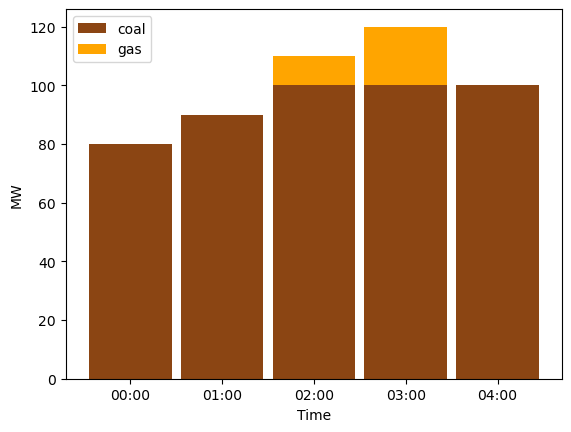

In [103]:
def plot_dispatch(n):
    df = n.generators_t.p
    colors = {"coal": "#8B4513", "gas": "#FFA500"}
    df = df[["coal", "gas"]]
    df.plot(kind="bar", stacked=True, width=0.9, color=[colors[c] for c in df.columns])
    plt.xticks(np.arange(len(df.index)), df.index.strftime("%H:%M"))
    plt.xticks(rotation=0)
    plt.xlabel("Time")
    plt.ylabel("MW")
    plt.legend(loc="upper left")
    plt.show()


plot_dispatch(n)

### Explore & discuss duals

In [96]:
n.model.dual

<xarray.Dataset>
Dimensions:                (snapshot: 5, Generator-fix: 2, Bus: 1)
Coordinates:
  * snapshot               (snapshot) datetime64[ns] 2019-01-01 ... 2019-01-0...
  * Generator-fix          (Generator-fix) object 'gas' 'coal'
  * Bus                    (Bus) object 'UA'
Data variables:
    Generator-fix-p-lower  (snapshot, Generator-fix) float64 30.0 0.0 ... 0.0
    Generator-fix-p-upper  (snapshot, Generator-fix) float64 0.0 0.0 ... 0.0 0.0
    Bus-nodal_balance      (snapshot, Bus) float64 40.0 40.0 70.0 70.0 40.0

### Explore & discuss spot market dispatch VS model's representation


In [ ]:
# https://www.epexspot.com/en/market-data